## Imports

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [2]:
def solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c):
   
    row, col = u.shape

    #fill the update of u   
    for n in range(nt):
        for i in range(1,nx-2):
            for j in range(1,ny-2):
                u[i,j]=u[i,j]-c*(dt/dx)*(u[i,j]-u[i-1,j])-c*(dt/dy)*(u[i,j]-u[i,j-1])
        u[0,:]=1
        u[ny-1,:]=1
        u[:,0]=1
        u[:,nx-1]=1   
    return 0

## Numba accelerator

In [3]:
@njit(fastmath=True)
def solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c):
   
    row, col = u.shape

    #fill the update of u   
    for n in range(nt):
        for i in range(1,nx-2):
            for j in range(1,ny-2):
                u[i,j]=u[i,j] -c*(dt/dx)*(u[i,j]-u[i-1,j])-c*(dt/dy)*(u[i,j]-u[i,j-1]) 
        u[0,:]=1
        u[ny-1,:]=1
        u[:,0]=1
        u[:,nx-1]=1 
               
    return 0

## Pyccel accelerator

In [4]:
@types('float[:,:]','float[:,:]','int', 'float', 'float','float', 'float')
def solve_2d_linearconv_pyccel(u, un, nt, dt, dx, dy, c):
   
    row, col = u.shape

    #fill the update of u and v   
    for n in range(nt):
        for i in range(1,row-1):
            for j in range(1,col-1):
                u[i,j]=u[i,j] -c*(dt/dx)*(u[i,j]-u[i-1,j])-c*(dt/dy)*(u[i,j]-u[i,j-1]) 
        u[0,:]=1
        u[row-1,:]=1
        u[:,0]=1
        u[:,col-1]=1        
               
    return 0

## Inputs

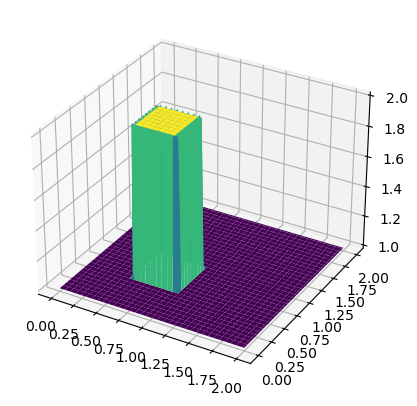

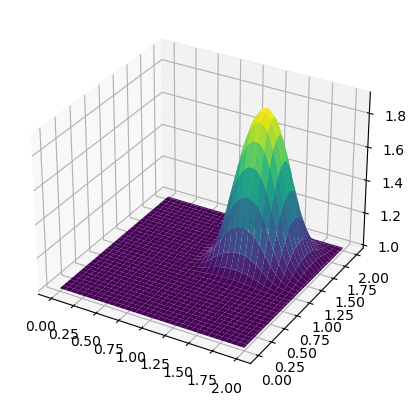

In [5]:
###variable declarations
nx = 101
ny = 101
nt = 100
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u0 = np.ones((ny, nx)) ##create a 1xn vector of 1's
u0[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
u = u0.copy()
un = np.ones((ny, nx)) 

solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u0[:], cmap=cm.viridis)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)

## Call Funtions

### Pure function

In [6]:
%timeit solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

3.34 s ± 46.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with numba accelerator

In [7]:
%timeit solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c)

6.83 ms ± 65.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with pyccel accelerator

In [8]:
solve_2d_linearconv_f90 = epyccel(solve_2d_linearconv_pyccel)

In [9]:
%timeit solve_2d_linearconv_f90(u, un, nt, dt, dx, dy, c)

9.18 ms ± 56.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
